In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [8]:
# 1. Daten laden
file_path = "../data/processed/charging_sessions_cleaned.csv"
data = pd.read_csv(file_path, parse_dates=["connectionTime", "disconnectTime", "doneChargingTime"])

# 2. Feature-Engineering
# Berechnung der durchschnittlichen Ladeleistung
data['averageChargingPower'] = data['kWhDelivered'] / ((data['disconnectTime'] - data['connectionTime']).dt.total_seconds() / 3600)

# Berechnung der Standortauslastung
# Anzahl der gleichzeitigen Ladevorgänge pro Standort und Zeiteinheit
data['connectionStart'] = data['connectionTime'].dt.floor('min')
data['connectionEnd'] = data['disconnectTime'].dt.floor('min')
occupancy = []
for index, row in data.iterrows():
    count = data[(data['siteID'] == row['siteID']) &
                 (data['connectionTime'] <= row['disconnectTime']) &
                 (data['disconnectTime'] >= row['connectionTime'])].shape[0]
    occupancy.append(count)
data['siteOccupancy'] = occupancy

data['hourOfDay'] = data['connectionTime'].dt.hour  # Stunde des Tages aus connectionTime

data = data.dropna(subset=['hourOfDay', 'averageChargingPower', 'siteID', 'siteOccupancy'])



Analyse für SiteID=1
Mean Squared Error (MSE) für averageChargingPower (SiteID=1): 3.6961


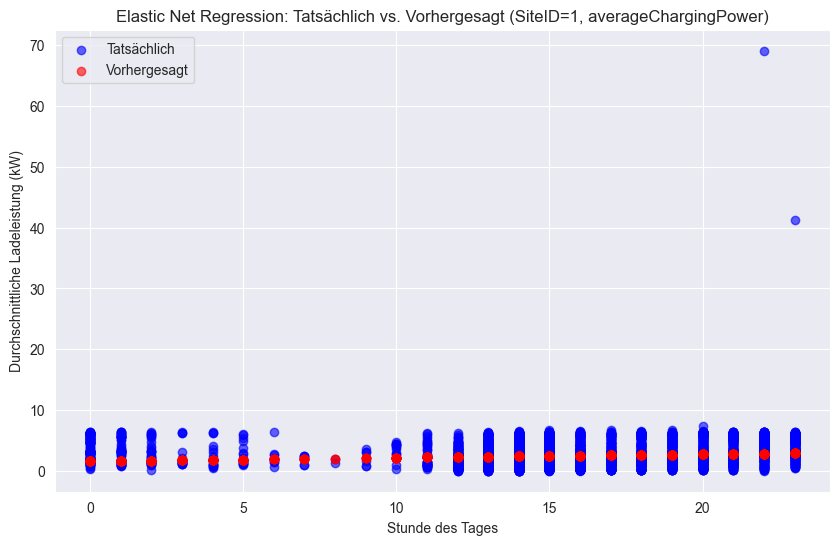

Mean Squared Error (MSE) für siteOccupancy (SiteID=1): 866.2261


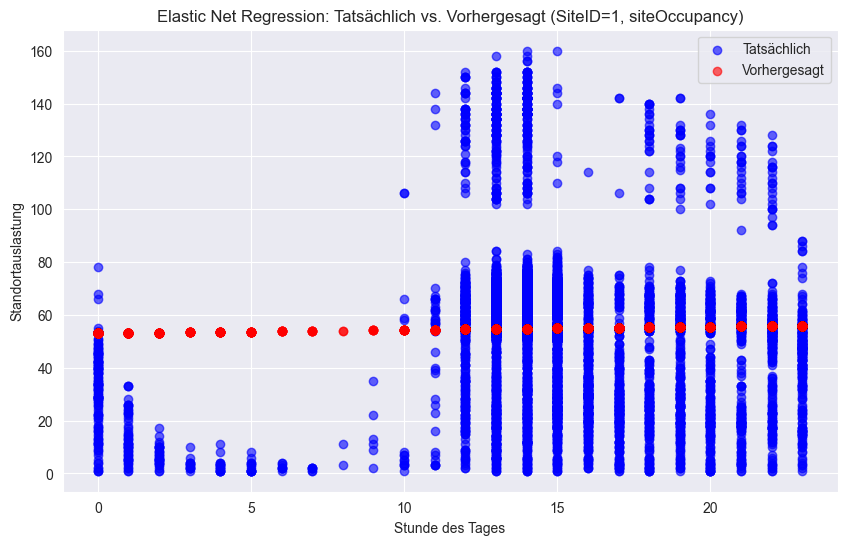


Analyse für SiteID=2
Mean Squared Error (MSE) für averageChargingPower (SiteID=2): 32.2686


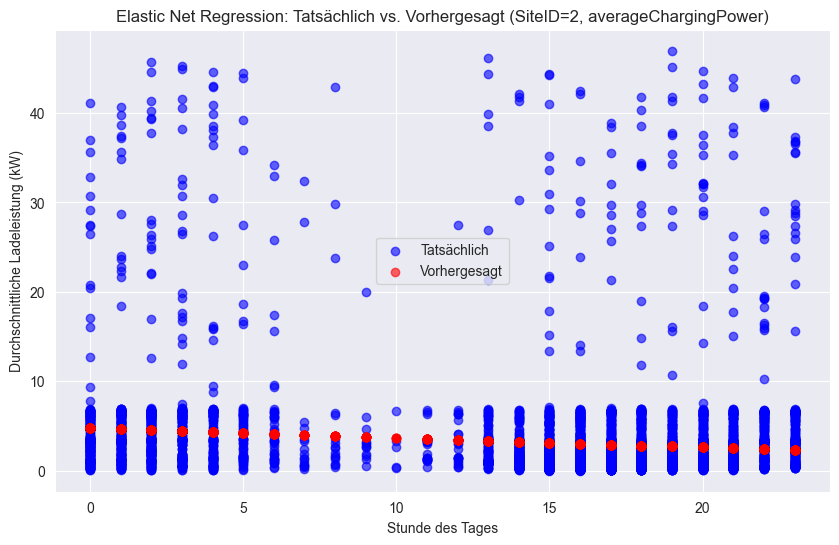

Mean Squared Error (MSE) für siteOccupancy (SiteID=2): 433.7644


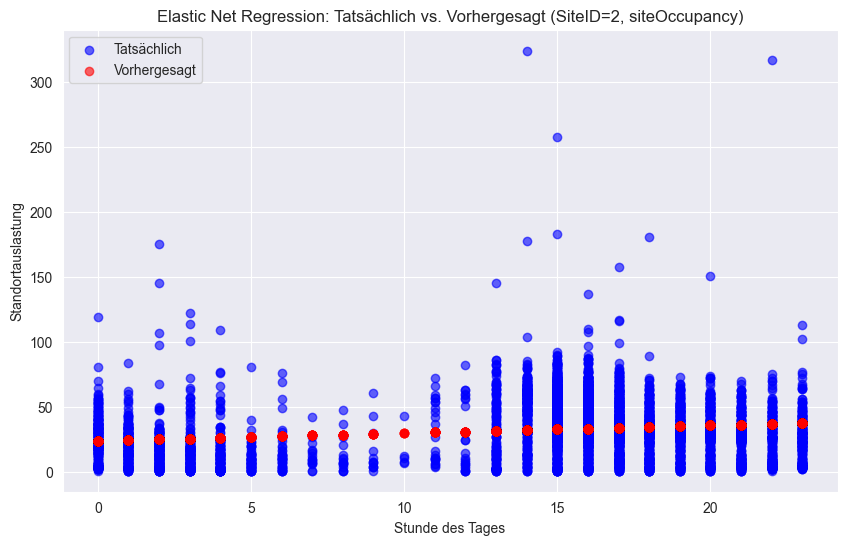

In [7]:
# Analyse für SiteID=1 und SiteID=2
for site in [1, 2]:
    print(f"\nAnalyse für SiteID={site}")
    site_data = data[data['siteID'] == site]

    # 3. Features und Zielvariable festlegen (1. Modell: averageChargingPower)
    X = site_data[['hourOfDay']]
    y = site_data['averageChargingPower']

    # 4. Daten normalisieren
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 5. Daten in Trainings- und Testdaten aufteilen
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # 6. Elastic Net Modell erstellen und trainieren
    elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
    elastic_net.fit(X_train, y_train)

    # 7. Modell evaluieren
    # Vorhersagen erstellen
    y_pred = elastic_net.predict(X_test)

    # Fehler berechnen
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error (MSE) für averageChargingPower (SiteID={site}): {mse:.4f}")

    # 8. Visualisierung der Ergebnisse
    plt.figure(figsize=(10, 6))
    plt.scatter(X_test * scaler.scale_ + scaler.mean_, y_test, alpha=0.6, color="blue", label="Tatsächlich")
    plt.scatter(X_test * scaler.scale_ + scaler.mean_, y_pred, alpha=0.6, color="red", label="Vorhergesagt")
    plt.xlabel("Stunde des Tages")
    plt.ylabel("Durchschnittliche Ladeleistung (kW)")
    plt.title(f"Elastic Net Regression: Tatsächlich vs. Vorhergesagt (SiteID={site}, averageChargingPower)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 9. Modell speichern (1. Modell)
    results = pd.DataFrame({"HourOfDay": X_test.flatten() * scaler.scale_[0] + scaler.mean_[0],
                            "Actual": y_test, "Predicted": y_pred})
    results.to_csv(f"elastic_net_results_site{site}_chargingpower.csv", index=False)

    # 3. Features und Zielvariable festlegen (2. Modell: siteOccupancy)
    X = site_data[['hourOfDay']]
    y = site_data['siteOccupancy']

    # 4. Daten normalisieren
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 5. Daten in Trainings- und Testdaten aufteilen
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # 6. Elastic Net Modell erstellen und trainieren
    elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
    elastic_net.fit(X_train, y_train)

    # 7. Modell evaluieren
    # Vorhersagen erstellen
    y_pred = elastic_net.predict(X_test)

    # Fehler berechnen
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error (MSE) für siteOccupancy (SiteID={site}): {mse:.4f}")

    # 8. Visualisierung der Ergebnisse
    plt.figure(figsize=(10, 6))
    plt.scatter(X_test * scaler.scale_ + scaler.mean_, y_test, alpha=0.6, color="blue", label="Tatsächlich")
    plt.scatter(X_test * scaler.scale_ + scaler.mean_, y_pred, alpha=0.6, color="red", label="Vorhergesagt")
    plt.xlabel("Stunde des Tages")
    plt.ylabel("Standortauslastung")
    plt.title(f"Elastic Net Regression: Tatsächlich vs. Vorhergesagt (SiteID={site}, siteOccupancy)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 9. Modell speichern (2. Modell)
    results = pd.DataFrame({"HourOfDay": X_test.flatten() * scaler.scale_[0] + scaler.mean_[0],
                            "Actual": y_test, "Predicted": y_pred})
    results.to_csv(f"elastic_net_results_site{site}_occupancy.csv", index=False)
